# Paper numbers & figures

## Import libraries

In [1]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysankey import sankey  # https://github.com/Pierre-Sassoulas/pySankey
from upsetplot import UpSet  # https://upsetplot.readthedocs.io/en/stable/index.html
from upsetplot import plot as UPplot
import yaml

pd.set_option("display.max_colwidth", None)

## Load data

All data files should be located in `../data/`

In [2]:
df = pd.DataFrame()
for repository in ["zenodo", "figshare", "osf"]:
    datasets = pd.read_csv(
        f"../data/{repository}_datasets.tsv",
        sep="\t",
        dtype={"dataset_id": str}
    )
    print(f"{repository}: found {datasets.shape[0]} datasets.")
    files = pd.read_csv(
        f"../data/{repository}_files.tsv",
        sep="\t",
        dtype={"dataset_id": str, "file_type": str,
               "file_md5": str, "file_url": str}
    )
    print(f"{repository}: found {files.shape[0]} files.")
    tab = pd.merge(files, datasets, how="left", on=["dataset_id", "dataset_origin"], validate="many_to_one")
    print(f"{repository}: merged dataframe has {tab.shape[0]} entries.\n")
    df = pd.concat([df, tab], ignore_index=True)

print(f"Dimensions of the final dataframe: {len(df)} lines (files) x {df.shape[1]} columns")

zenodo: found 996 datasets.
zenodo: found 154375 files.
zenodo: merged dataframe has 154375 entries.

figshare: found 906 datasets.
figshare: found 79075 files.
figshare: merged dataframe has 79075 entries.

osf: found 67 datasets.
osf: found 6148 files.
osf: merged dataframe has 6148 entries.

Dimensions of the final dataframe: 239598 lines (files) x 18 columns


## Assign year

In [3]:
df["year"] = df["date_creation"].apply(lambda x: int(x[:4]))

## Number of datasets and files by data repository

In [4]:
# Add columns for easier aggregation
df["_is_zip_file"] = np.where((df["file_type"] == "zip"), True, False)
df["_is_not_from_zip_file"] = ~ df["from_zip_file"]
df["_size_not_from_zip_file"] = np.where((df["from_zip_file"] == False), df["file_size"]/1E9, 0.0)
dataset_agg = (df
 .groupby("dataset_origin")
 .agg(
     number_of_datasets=("dataset_id", "nunique"),
     date_first_dataset=("date_creation", "min"),
     date_last_dataset=("date_creation", "max"),
     files_from_datasets=("_is_not_from_zip_file", "sum"),
     total_size_in_GB=("_size_not_from_zip_file", "sum"),
     zip_files=("_is_zip_file", "sum"),
     files_from_zip_files=("from_zip_file", "sum"),
     total_files=("dataset_id", "count")
 )
)
dataset_agg.loc["total"] = dataset_agg.sum(numeric_only=True)
dataset_agg.style.format(thousands=",", precision=0)

,number_of_datasets,date_first_dataset,date_last_dataset,files_from_datasets,total_size_in_GB,zip_files,files_from_zip_files,total_files
dataset_origin,,,,,,,,
figshare,906,2012-08-20,2023-02-03,"3,235",745,589,"75,840","79,075"
osf,60,2017-05-24,2023-01-17,"6,148",489,14,0,"6,148"
zenodo,996,2014-11-19,2023-02-03,"19,697","12,562","1,598","134,678","154,375"
total,"1,962",nan,nan,"29,080","13,796","2,201","210,518","239,598"


<div class="alert alert-info">
Files found in zip files are almost 8 times more numerous than files found directly in datasets.

In the following, we will considere all files (found directly in datasets and extracted from zip files).
</div>

### Assign MD engine

In [5]:
file_types_list = []
with open("../params/file_types.yml", "r") as param_file:
    data_loaded = yaml.safe_load(param_file)
    file_types_list = data_loaded["file_types"]

    ext_gromacs = []
ext_namd = []
ext_amber = []
ext_charmm = []
ext_desmond = []

list_coordinate = []
list_trajectory = []
list_topology = []

for type_dict in file_types_list:
    # assign MD engine
    if type_dict["engine"] == "gromacs":
        ext_gromacs.append(type_dict["type"])
    elif type_dict["engine"] == "namd":
        ext_namd.append(type_dict["type"])
    elif type_dict["engine"] == "amber":
        ext_amber.append(type_dict["type"])
    elif type_dict["engine"] == "charmm":
        ext_charmm.append(type_dict["type"])
    elif type_dict["engine"] == "desmond":
        ext_desmond.append(type_dict["type"])
    # assign file category
    if type_dict["category"] == "coordinate":
        list_coordinate.append(type_dict["type"])
    elif type_dict["category"] == "topology":
        list_topology.append(type_dict["type"])
    elif type_dict["category"] == "trajectory":
        list_trajectory.append(type_dict["type"])

ext_all = ext_gromacs + ext_namd + ext_amber + ext_charmm
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in (ext_namd + ext_charmm):
        return "NAMD/CHARMM"
    elif file_type in ext_amber:
        return "AMBER"
    elif file_type in ext_desmond:
        return "DESMOND"
    else:
        return "Unknown"

df["MD_engine"] = df["file_type"].apply(assign_md_engine)

### Number of datasets and files per MD engine

In [6]:
(df
 .groupby("MD_engine")
 .agg(
     datasets=("dataset_id", "nunique"),
     files=("dataset_id", "count")
 ).style.format(thousands=",", precision=0)
)

,datasets,files
MD_engine,,
AMBER,229,"9,826"
DESMOND,48,"1,855"
GROMACS,"1,242","83,731"
NAMD/CHARMM,664,"12,312"
Unknown,"1,151","131,874"


### Assign category

In [7]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

df["category"] = df["file_type"].apply(assign_file_category)
df["category"].value_counts()

none          167966
trajectory     35355
topology       29553
coordinate      6724
Name: category, dtype: int64

## Figure 1

Evolution of number of “molecular dynamics” papers in PubMed vs time

See notebook `search_MD_in_pubmed.ipynb`.

## Figure 2

### 2.B. Evolution of the number MD files deposited in data repositories

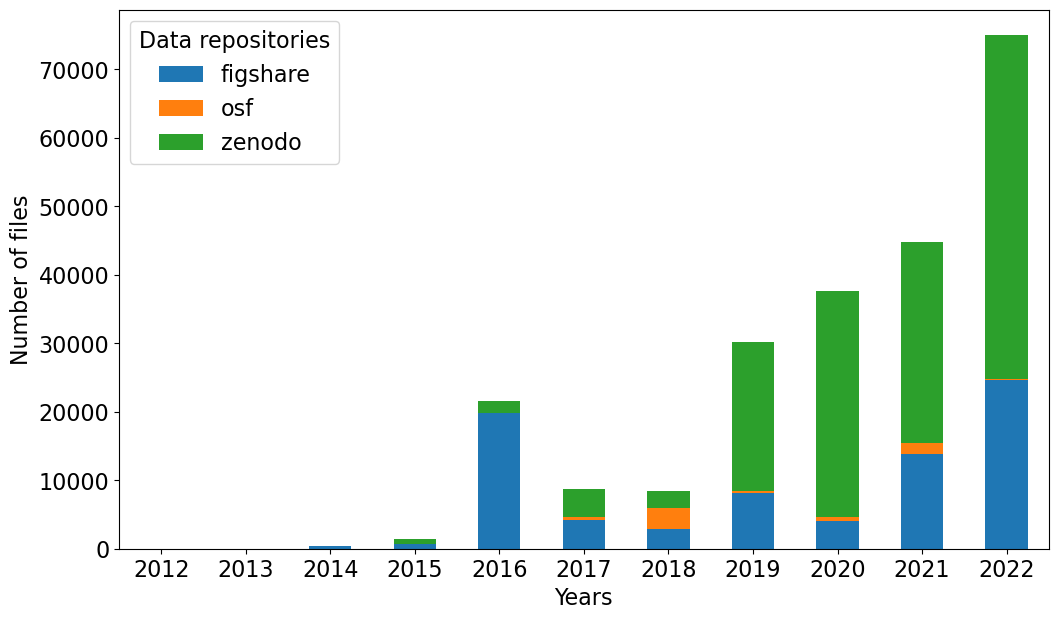

In [8]:
plt.rcParams.update({"font.size": 16})
(df
 .query("year != 2023")
 .groupby(["year", "dataset_origin"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="Data repositories")
filename = "fig/number_of_files_per_years_per_data_repositories"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.B. MD engines distribution

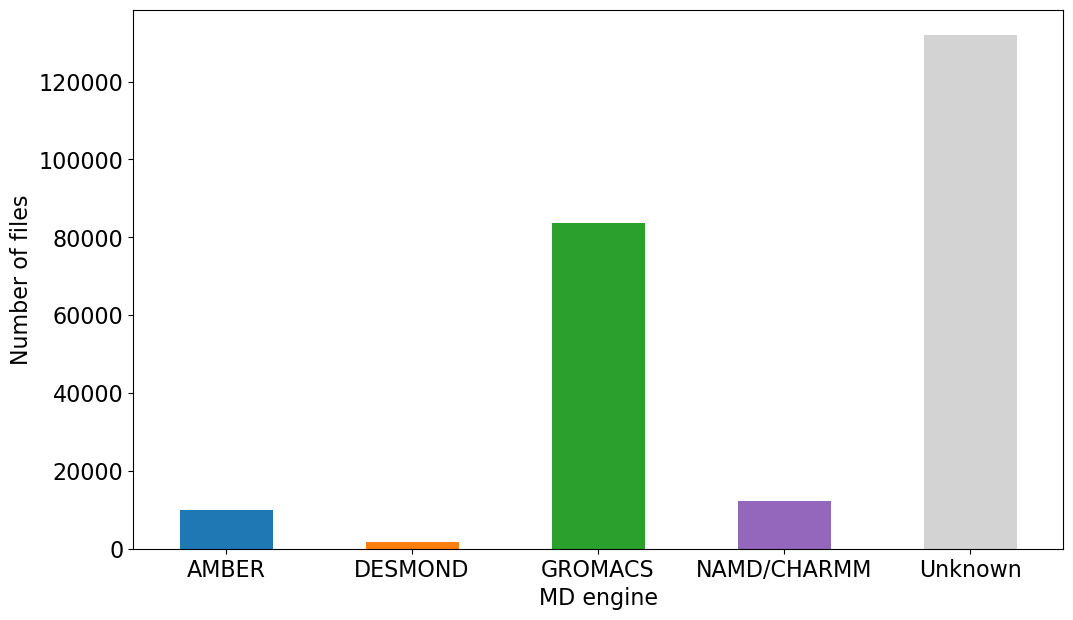

In [9]:
plt.rcParams.update({'font.size': 16})
(df
 .loc[:, "MD_engine"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple", "lightgrey"], figsize=(12,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

### 2.C. Type of files not associated to any MD engine

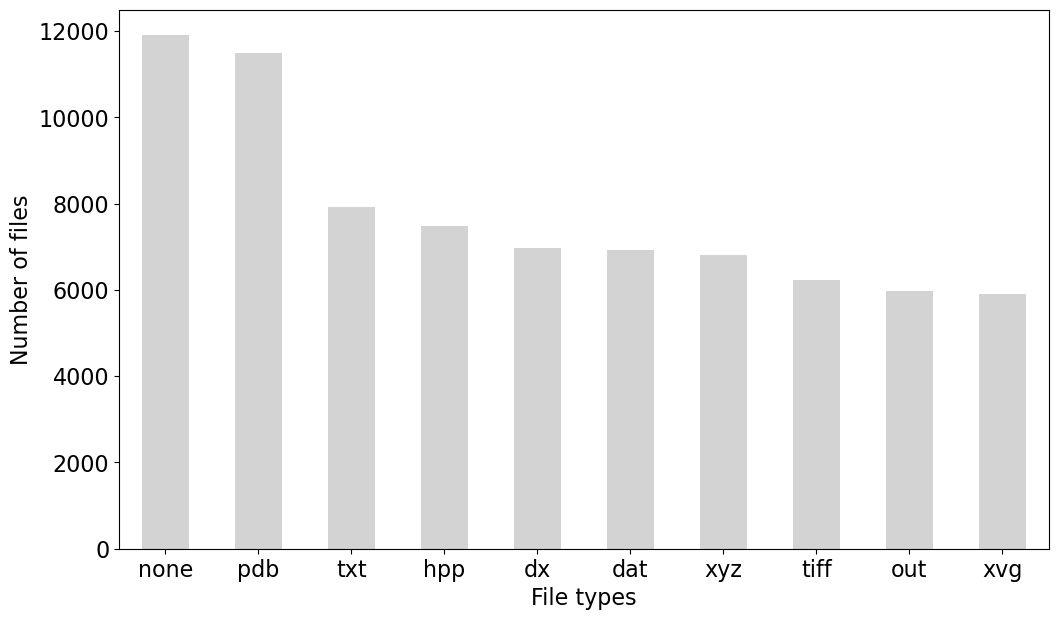

In [10]:
plt.rcParams.update({"font.size": 16})
(df
 .query("MD_engine == 'Unknown'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="lightgrey", figsize=(12,7))
)
plt.xlabel("File types")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
filename = "fig/number_of_files_per_filetype_no_MD_engine"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

Most files with no file type are simulation snapshots, log or README files.

## Figure 3

### 3.A. Gromacs file types by categories

10 most frequent Gromacs file types

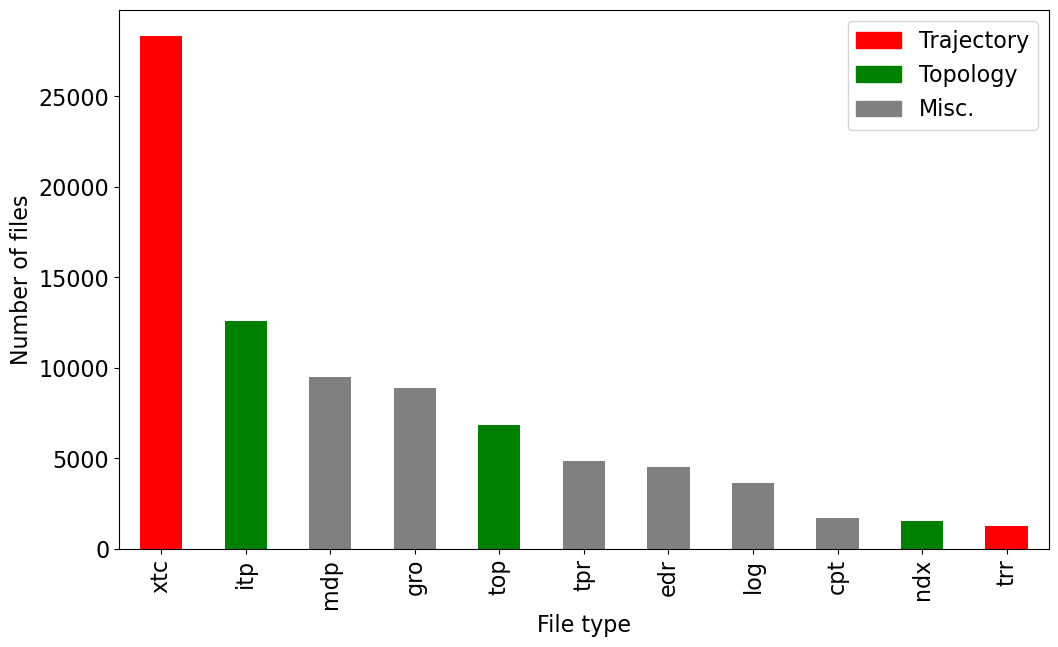

In [11]:
colors={
    "trajectory":"red",
    "topology":"green",
    "none":"grey"
}
gromacs_file_types = (df
 .query("MD_engine == 'GROMACS'")
 .groupby("file_type").agg({"category": "first", "file_name": "count"})
 .sort_values(by="file_name", ascending=False)
)
plt.rcParams.update({'font.size': 16})
gromacs_file_types["color"] = gromacs_file_types["category"].map(colors)
gromacs_file_types.plot(kind="bar", y="file_name", figsize=(12,7), color=gromacs_file_types["color"])
plt.xlabel("File type")
plt.ylabel("Number of files")
# Custom legend.
traj_patch = mpatches.Patch(color="red", label="Trajectory")
topol_patch = mpatches.Patch(color="green", label="Topology")
misc_patch = mpatches.Patch(color="grey", label="Misc.")
plt.legend(handles=[traj_patch, topol_patch, misc_patch])
filename = "fig/number_of_files_by_Gromacs_filetype"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

In [12]:
gromacs_files = df.query("MD_engine == 'GROMACS'")
print(
    f"Total of {gromacs_files.shape[0]} Gromacs files "
    f"from {gromacs_files['dataset_id'].nunique()} datasets."
)

Total of 83731 Gromacs files from 1242 datasets.


### 3.B. Cumulated distribution of gro files

In [13]:
gro_df = pd.read_csv("../data/gromacs_gro_files_info.tsv", sep="\t")
gro_df = pd.merge(
    gro_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {len(gro_df)} gro files")
gro_df.head()

Dataset has 8671 gro files


,dataset_origin,dataset_id,file_name,atom_number,has_protein,has_nucleic,has_lipid,has_glucid,has_water_ion,dataset_url
0,zenodo,1043926,DPPC-298K-42-CA.gro,229788.0,False,False,True,False,True,https://zenodo.org/record/1043926
1,zenodo,1043926,DPPC-298K-48-CA.gro,229788.0,False,False,True,False,True,https://zenodo.org/record/1043926
2,zenodo,1043926,DPPC-298K-54-CA.gro,229788.0,False,False,True,False,True,https://zenodo.org/record/1043926
3,zenodo,1043926,DPPC-298K-60-CA.gro,229788.0,False,False,True,False,True,https://zenodo.org/record/1043926
4,zenodo,1043926,DPPC-298K-66-CA.gro,229788.0,False,False,True,False,True,https://zenodo.org/record/1043926


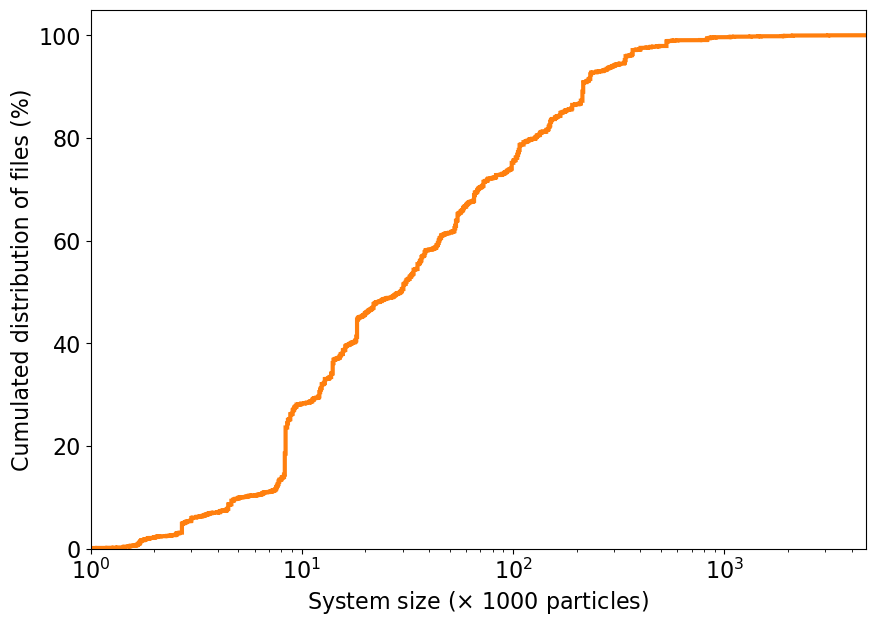

In [14]:
def plot_system_size_distribution(df):
    """Plot system size distribution"""
    # Convert system size to k-particules (1000) 
    df["k_particles"] = gro_df["atom_number"] / 1000

    logbins = np.geomspace(df["k_particles"].min()+1, df["k_particles"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["k_particles"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True, density=True
    )
    ax.set_xlabel(r"System size ($\times$ 1000 particles)")
    ax.set_ylabel("Cumulated distribution of files (%)")
    ax.set_yticks(np.arange(0, 1.1, 0.2), [f"{value:.0f}" for value in np.arange(0, 1.1, 0.2)*100])
    ax.set_xscale("log")
    ax.set_xlim(1, df["k_particles"].max() - df["k_particles"].max()*0.1)
    filename = "fig/gromacs_gro_system_size_cumulated_distribution"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_system_size_distribution(gro_df)

Smallest systems:

In [15]:
(gro_df
 .query("atom_number < 5")
 .sort_values(by="atom_number", ascending=True)
 #.to_csv("system_size_below_5_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,file_name,atom_number,has_protein,has_nucleic,has_lipid,has_glucid,has_water_ion,dataset_url,k_particles
8115,figshare,8846045,Tutorial/gro/cell.gro,2.0,False,False,False,False,False,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045,0.002
6841,figshare,5190502,H2O_v2.gro,3.0,False,False,False,False,False,https://tandf.figshare.com/articles/dataset/Organic_and_Third_Phase_in_HNO_sub_3_sub_TBP_i_n_i_-Dodecane_System_No_Reverse_Micelles/5190502,0.003
6860,figshare,12517490,topolpgy_backmapping_files/topologies/Benzene/benzene_cg.gro,3.0,False,False,False,False,False,https://acs.figshare.com/articles/dataset/Capturing_Protein_Ligand_Recognition_Pathways_in_Coarse-Grained_Simulation/12517490,0.003
7920,figshare,19534516,setup_files/2_packmol/CO2.gro,3.0,False,False,False,False,False,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
7921,figshare,19534516,setup_files/2_packmol/H2O.gro,3.0,False,False,False,False,True,https://figshare.com/articles/dataset/All-atom_molecular_simulation_study_of_cellulose_acetate_amorphous_structure_and_the_dissolution_of_small_molecule/19534516,0.003
7845,figshare,11702442,ct9b01139_si_001/Topology_Files/AMMONIA/AMMONIA_GMX.gro,4.0,False,False,False,False,False,https://acs.figshare.com/articles/dataset/Alchemical_Hydration_Free-Energy_Calculations_Using_Molecular_Dynamics_with_Explicit_Polarization_and_Induced_Polarity_Decoupling_An_On_the_Fly_Polarization_Approach/11702442,0.004


Systems with about 1 k particles:

In [16]:
(gro_df
 .query("atom_number > 8_400")
 .query("atom_number < 8_500")
 .sort_values(by="atom_number", ascending=False)
 #.to_csv("system_size_between_8400_and_8500_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,file_name,atom_number,has_protein,has_nucleic,has_lipid,has_glucid,has_water_ion,dataset_url,k_particles
4294,zenodo,4371296,input_files/metad/SC-ANGLE/cterm/e0/equi.gro,8443.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.443
4295,zenodo,4371296,input_files/metad/SC-ANGLE/cterm/n3/equi.gro,8443.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.443
4296,zenodo,4371296,input_files/metad/SC-ANGLE/cterm/p3/equi.gro,8443.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.443
4297,zenodo,4371296,input_files/metad/SC-ANGLE/nterm/e0/equi.gro,8443.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.443
4298,zenodo,4371296,input_files/metad/SC-ANGLE/nterm/n3/equi.gro,8443.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.443
...,...,...,...,...,...,...,...,...,...,...,...
4407,zenodo,4371296,input_files/umbrella/mag2/local/ads_ins/nterm+charge/25.gro,8428.0,True,False,True,False,True,https://zenodo.org/record/4371296,8.428
2304,zenodo,7061501,Martini3_scaling/GpA/POPC/scaling_09/bilayer_assembly46.gro,8415.0,True,False,True,False,True,https://zenodo.org/record/7061501,8.415
2494,zenodo,7061501,Martini3_scaling/GpA/POPC/scaling_95/bilayer_assembly46.gro,8415.0,True,False,True,False,True,https://zenodo.org/record/7061501,8.415
2404,zenodo,7061501,Martini3_scaling/GpA/POPC/scaling_92/bilayer_assembly46.gro,8415.0,True,False,True,False,True,https://zenodo.org/record/7061501,8.415


Largest systems:

In [17]:
(gro_df
 .query("atom_number > 2_000_000")
 .sort_values(by="atom_number", ascending=False)
 #.to_csv("system_size_above_5_000_000_particles.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,file_name,atom_number,has_protein,has_nucleic,has_lipid,has_glucid,has_water_ion,dataset_url,k_particles
7186,figshare,1238172,water01.gro,5184000.0,False,False,False,False,True,https://figshare.com/articles/dataset/water01_gro_Water_coordinate_file_for_cryo_EM_image_simulation/1238172,5184.000
1734,zenodo,3634884,PM_large_lastframe.noW.gro,3522816.0,True,False,True,False,True,https://zenodo.org/record/3634884,3522.816
3305,zenodo,6797842,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_2200ns.gro,3113594.0,True,False,True,False,True,https://zenodo.org/record/6797842,3113.594
3306,zenodo,6797842,simulations/protein_simulations/prepore/33mer_largemembrane/prepore_33mer_largemembrane_equilibrated.gro,3113594.0,True,False,True,False,True,https://zenodo.org/record/6797842,3113.594
7536,figshare,14919822,Data_share/SMD_data/SMD_structure_data/OUTPUT/Spike_CR3022-4A8/Spike-4A8_1_pull_005.gro,2621751.0,True,False,False,False,True,https://acs.figshare.com/articles/dataset/Electrostatic_Interactions_Explain_the_Higher_Binding_Affinity_of_the_CR3022_Antibody_for_SARS-CoV_2_than_the_4A8_Antibody/14919822,2621.751
3286,zenodo,6797842,simulations/protein_simulations/pore/27mer/27mer_4100ns.gro,2125422.0,True,False,True,False,True,https://zenodo.org/record/6797842,2125.422
3287,zenodo,6797842,simulations/protein_simulations/pore/27mer/27mer_equilibrated.gro,2125422.0,True,False,True,False,True,https://zenodo.org/record/6797842,2125.422
3290,zenodo,6797842,simulations/protein_simulations/pore/33mer/33mer_5000ns.gro,2119785.0,True,False,True,False,True,https://zenodo.org/record/6797842,2119.785
3291,zenodo,6797842,simulations/protein_simulations/pore/33mer/33mer_70C_1500ns.gro,2119785.0,True,False,True,False,True,https://zenodo.org/record/6797842,2119.785
3292,zenodo,6797842,simulations/protein_simulations/pore/33mer/33mer_equilibrated.gro,2119785.0,True,False,True,False,True,https://zenodo.org/record/6797842,2119.785


### 3.C. System composition

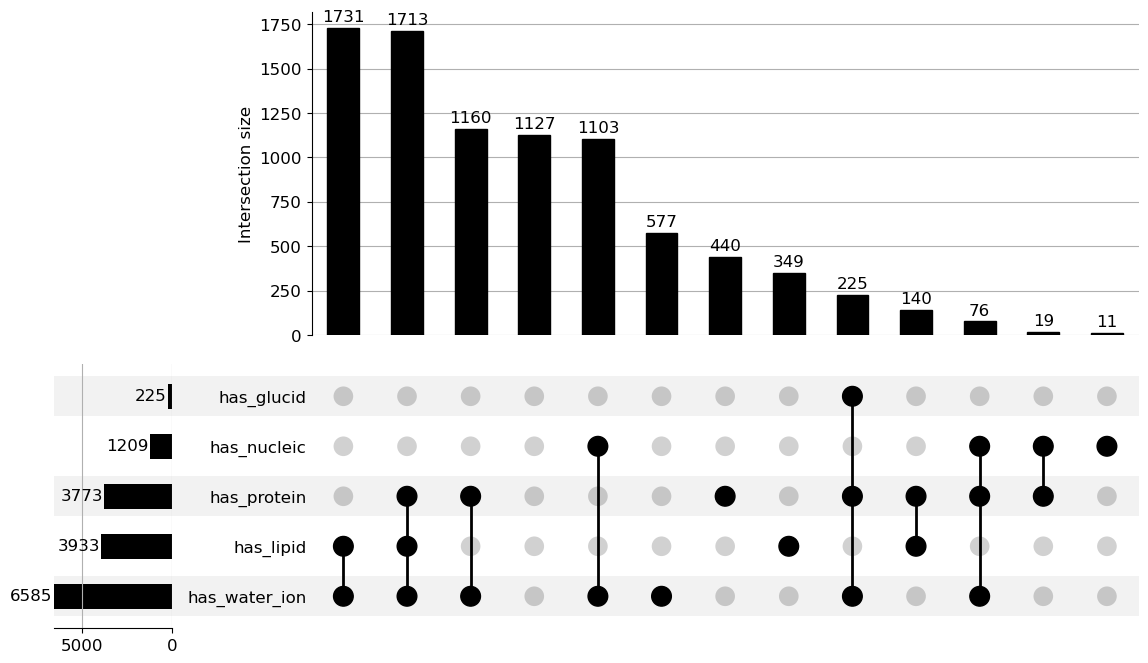

In [18]:
# Create pivot dataframe
df_upset = pd.pivot_table(
    gro_df, 
    index=["has_protein", "has_lipid", "has_nucleic", "has_water_ion", "has_glucid"], 
    values=["file_name"], 
    aggfunc=len
)
# Convert pivot dataframe to Pandas Series with multi-index
sr_upset = pd.Series(index=df_upset.index, data=df_upset.values.flatten(), name="value")
plt.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 8))
UPplot(sr_upset, fig=fig, show_counts=True, element_size=None, sort_by="cardinality")
filename = "fig/gromacs_system_composition"
plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{filename}.svg", bbox_inches="tight")

Systems without protein, lipid, nucleic acid, water, ion nor glucid:

In [19]:
(gro_df
 .query("has_protein == False")
 .query("has_water_ion == False")
 .query("has_lipid == False")
 .query("has_nucleic == False")
 .query("has_glucid == False")
 #.to_csv("systems_without_protein_water_ion_lipid_nucleic_acid_glucid.tsv", sep="\t", index=False)
)

,dataset_origin,dataset_id,file_name,atom_number,has_protein,has_nucleic,has_lipid,has_glucid,has_water_ion,dataset_url,k_particles
1706,zenodo,7125315,3b_START.gro,5583.0,False,False,False,False,False,https://zenodo.org/record/7125315,5.583
1707,zenodo,7125315,3c_START.gro,5844.0,False,False,False,False,False,https://zenodo.org/record/7125315,5.844
1708,zenodo,7125315,4a_START.gro,4374.0,False,False,False,False,False,https://zenodo.org/record/7125315,4.374
1709,zenodo,7125315,4b_START.gro,4410.0,False,False,False,False,False,https://zenodo.org/record/7125315,4.410
1710,zenodo,7125315,DMF.gro,12.0,False,False,False,False,False,https://zenodo.org/record/7125315,0.012
...,...,...,...,...,...,...,...,...,...,...,...
8666,osf,4aghb,PtB-b-force field/em4_nojump.gro,18432.0,False,False,False,False,False,https://osf.io/4aghb/,18.432
8667,osf,4aghb,PtB-b-force field/pr_nvt.gro,18432.0,False,False,False,False,False,https://osf.io/4aghb/,18.432
8668,osf,4aghb,PtB-b-force field/pr_nvt_nojump.gro,18432.0,False,False,False,False,False,https://osf.io/4aghb/,18.432
8669,osf,4aghb,PtB-b-force field/Production_10ns_PTI_noVs.gro,18432.0,False,False,False,False,False,https://osf.io/4aghb/,18.432


## Figure 4

### 4.A. Simulation temperature

In [171]:
mdp_df = pd.read_csv("../data/gromacs_mdp_files_info.tsv", sep="\t")
mdp_df = pd.merge(
    mdp_df,
    df[["dataset_origin", "dataset_id", "dataset_url"]].drop_duplicates(),
    on=["dataset_origin", "dataset_id"],
    how="left"
)
print(f"Dataset has {len(mdp_df)} mdp files")
mdp_df.head()

Dataset has 9496 mdp files


,dataset_origin,dataset_id,file_name,dt,nsteps,temperature,thermostat,barostat,dataset_url
0,zenodo,1043926,mono.mdp,0.002,100000000.0,298.0,v-rescale,no,https://zenodo.org/record/1043926
1,zenodo,1043946,mono.mdp,0.002,100000000.0,298.0,v-rescale,no,https://zenodo.org/record/1043946
2,zenodo,3463130,md.mdp,0.020,2500000.0,310.0,v-rescale,parrinello-rahman,https://zenodo.org/record/3463130
3,zenodo,1167532,md.mdp,0.002,100000000.0,298.0,nose-hoover,parrinello-rahman,https://zenodo.org/record/1167532
4,zenodo,3434100,1-POPC512_ECC-lipid14-CaCL_978mM_md_mdout.mdp,0.002,NaN,313.0,v-rescale,parrinello-rahman,https://zenodo.org/record/3434100


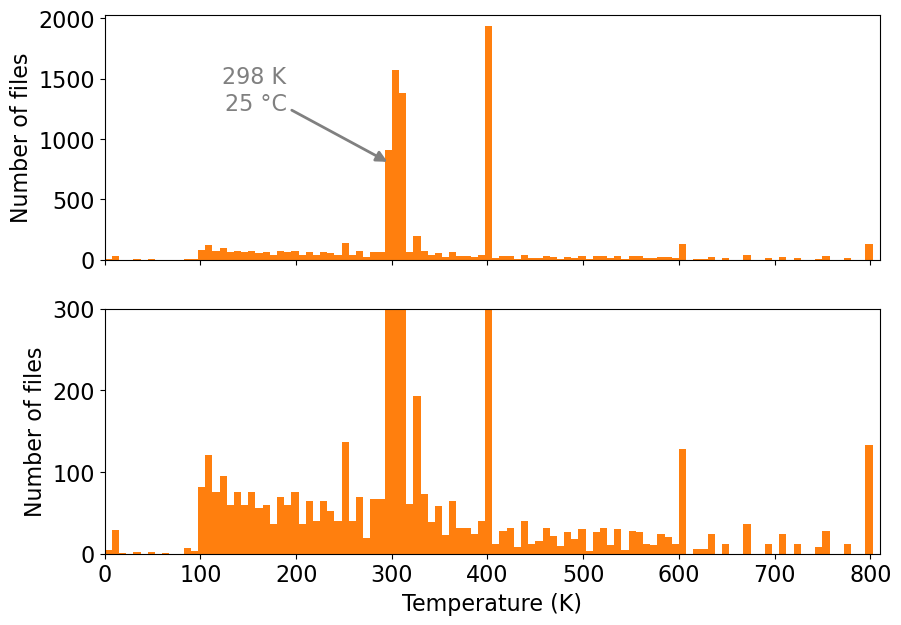

In [21]:
def plot_temperature_histogram(df):
    """Create plot for temperature distribution"""
    bins=200
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(2, sharex=True, figsize=(10,7))
    ax[0].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[0].set_ylabel("Number of files")
    ax[0].set_xlim(0, 810)
    ax[0].annotate("310 K\n37 °C", xy=(310, 2400), xytext=(450, 2750), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray", "connectionstyle":"arc3"}, 
                 horizontalalignment="left", verticalalignment="top")
    ax[0].annotate("298 K\n25 °C", xy=(298, 800), xytext=(190, 1200), color="gray",
                 arrowprops={"arrowstyle":"-|>", "lw":2, "color":"gray"}, 
                 horizontalalignment="right", verticalalignment="bottom")

    ax[1].hist(df["temperature"], bins=bins, color="tab:orange")
    ax[1].set_ylabel("Number of files")
    ax[1].set_ylim(0, 300)
    ax[1].set_xlabel("Temperature (K)")
    filename = "fig/gromacs_temperature_histogram"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_temperature_histogram(mdp_df)

### Systems with lowest temperatures

In [22]:
(mdp_df
 .query("temperature < 15")
 .sort_values(by="temperature", ascending=True)
 .head(10)
)

,dataset_origin,dataset_id,file_name,dt,nsteps,temperature,thermostat,barostat,dataset_url
9127,figshare,8846045,Tutorial/mdp/3_run.mdp,0.0300,1000000.0,0.0,Berendsen,berendsen,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
9059,figshare,7370684,md_files/2-MD-runs/mdp/1_grompp_minimisation.mdp,0.0020,5000.0,0.0,v-rescale,no,https://acs.figshare.com/articles/dataset/Stereospecific_1_3_H_Transfer_of_Indenols_Proceeds_via_Persistent_Ion-Pairs_Anchored_by_NH__Interactions/7370684
9126,figshare,8846045,Tutorial/mdp/2_nvt.mdp,0.0300,5000.0,0.0,Berendsen,no,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
9125,figshare,8846045,Tutorial/mdp/2_npt.mdp,0.0300,10000.0,0.0,Berendsen,berendsen,https://acs.figshare.com/articles/dataset/Nucleation_Mechanisms_of_Self-Assembled_Physisorbed_Monolayers_on_Graphite/8846045
9026,figshare,10269416,input_files/MD/production_REMD.mdp,0.0005,60000000.0,3.0,nose-hoover,Parrinello-Rahman,https://acs.figshare.com/articles/dataset/Adding_Anisotropy_to_the_Standard_Quasi-Harmonic_Approximation_Still_Fails_in_Several_Ways_to_Capture_Organic_Crystal_Thermodynamics/10269416
9025,figshare,10269416,input_files/MD/production.mdp,0.0005,10000000.0,10.0,nose-hoover,Parrinello-Rahman,https://acs.figshare.com/articles/dataset/Adding_Anisotropy_to_the_Standard_Quasi-Harmonic_Approximation_Still_Fails_in_Several_Ways_to_Capture_Organic_Crystal_Thermodynamics/10269416
7216,figshare,21644393,SI/Carbamazepine/GAFFTIP3P/Carbamazepine/Freeze_10/equilibration.mdp,0.0010,5000000.0,10.0,berendsen,no,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
7215,figshare,21644393,SI/Carbamazepine/GAFFTIP3P/Carbamazepine/Freeze_10/production.mdp,0.0010,0.0,10.0,berendsen,no,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
7081,figshare,21644393,SI/Carbamazepine/GAFFTIP3P/CarbamazepineLiq48/Freeze_10/equilibration.mdp,0.0010,5000000.0,10.0,berendsen,berendsen,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393
5479,figshare,21644393,SI/Gandotinib/GAFFTIP3P/Gandotinib/Freeze_10/equilibration.mdp,0.0010,5000000.0,10.0,berendsen,no,https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393


### Focus on spikes at 400, 600 & 800 K

In [48]:
(mdp_df
 .query("temperature == 400 | temperature == 600 | temperature == 800")
 .groupby(["dataset_origin", "dataset_id"])
 .size()
)

dataset_origin  dataset_id
figshare        21644393      2160
                4040661          1
                6384443          2
zenodo          20544            3
dtype: int64

We dig more with dataset 21644393:

In [24]:
(mdp_df
 .query("dataset_id == '21644393'")
 .value_counts(subset="temperature")
 .head()
)

temperature
400.0    1924
300.0     256
600.0     128
800.0     108
250.0      96
dtype: int64

Dataset [21644393](https://acs.figshare.com/articles/dataset/A_Comparison_of_Methods_for_Computing_Relative_Anhydrous_Hydrate_Stability_with_Molecular_Simulation/21644393) in Figshare:
> A Comparison of Methods for Computing Relative Anhydrous–Hydrate Stability with Molecular Simulation

This dataset has actually far more mdp files:

In [25]:
(mdp_df
 .query("dataset_id == '21644393'")
 .shape[0]
)

5256

5256 mdp files for a single dataset!

### Hightest temperatures

In [26]:
mdp_df.query("temperature > 800")

,dataset_origin,dataset_id,file_name,dt,nsteps,temperature,thermostat,barostat,dataset_url
9120,figshare,2267512,6P_crystal_reproduction_files/reproduction_files/NVT/nvt_annealing.mdp,0.001,6000000.0,1500.0,V-rescale,no,https://acs.figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512


Dataset [2267512](https://figshare.com/articles/dataset/Growth_and_Characterization_of_Molecular_Crystals_of_i_para_i_Sexiphenyl_by_All_Atom_Computer_Simulations/2267512) at 1500 K:

> Growth and Characterization of Molecular Crystals of para-Sexiphenyl by All-Atom Computer Simulations

## 4.B. Cumulated distribution of simulation time

In [27]:
# Compute simulation time:
# dt is in ps
# https://manual.gromacs.org/documentation/current/user-guide/mdp-options.html#mdp-dt
mdp_df["time"] = mdp_df["dt"] * mdp_df["nsteps"] / 1000
# in ns
# 1 µs = 1 000 ns

# Attribute all-atom (AA) or corase-grain (CG) simulation type
mdp_df["simulation_type"] = np.where(mdp_df["dt"] <= 0.01, "AA", "GG")

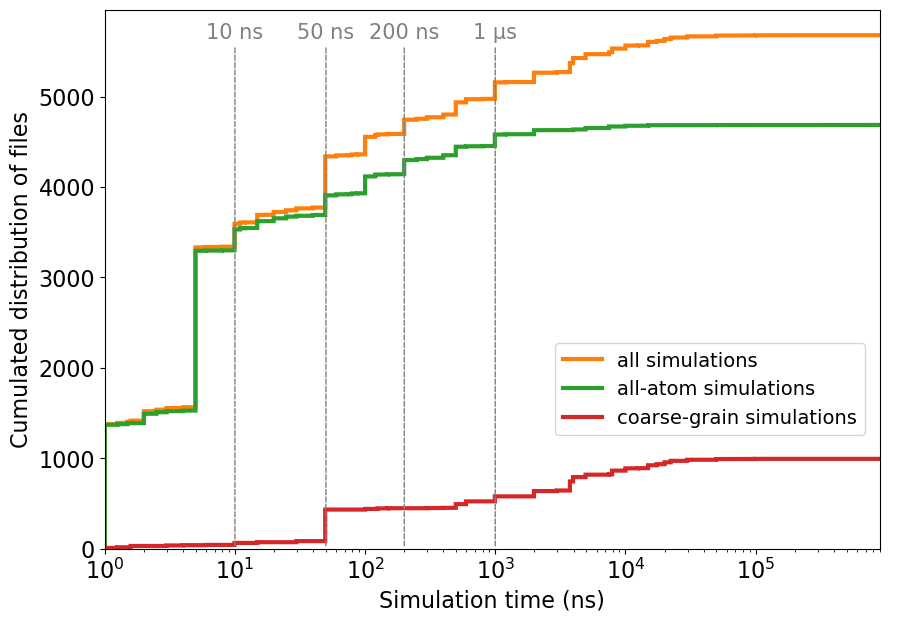

In [28]:
def plot_simulation_time_distribution(df):
    logbins = np.geomspace(df["time"].min()+1, df["time"].max(), 1_000)

    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    values, bins, _ = ax.hist(
        df["time"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True,
        label = "all simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["simulation_type"] == "AA" ]["time"], 
        bins=logbins,
        color="tab:green", linewidth=3,
        histtype="step", cumulative=True,
        label = "all-atom simulations"
    )
    values, bins, _ = ax.hist(
        df[ df["simulation_type"] == "GG" ]["time"], 
        bins=logbins,
        color="tab:red", linewidth=3,
        histtype="step", cumulative=True,
        label = "coarse-grain simulations"
    )
    ax.set_xlabel("Simulation time (ns)")
    ax.set_ylabel("Cumulated distribution of files")
    ax.set_xscale("log")
    ax.set_xlim(1, df["time"].max() - df["time"].max() * 0.1)
    text_y_position = 5600
    ax.annotate("10 ns", xy=(10, 0), xytext=(10, text_y_position), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("50 ns", xy=(50, 0), xytext=(50, text_y_position), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("200 ns", xy=(200, 0), xytext=(200, text_y_position), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    ax.annotate("1 µs", xy=(1000, 0), xytext=(1000, text_y_position), color="gray",
                 arrowprops={"arrowstyle":"-", "linestyle":"--", "lw":1, "color":"gray"}, 
                 horizontalalignment="center", verticalalignment="bottom", fontsize=15)
    legend_elements = [
        Line2D([0], [0], color="tab:orange", lw=3, label="all simulations"),
        Line2D([0], [0], color="tab:green", lw=3, label="all-atom simulations"),
        Line2D([0], [0], color="tab:red", lw=3, label="coarse-grain simulations")
    ]                   
    fig.legend(handles=legend_elements, loc=(0.61, 0.30), prop={"size":14})
    filename = "fig/gromacs_simulation_time"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_simulation_time_distribution(mdp_df)

### Simulations above 50 µs

In [29]:
mdp_df.query("time >= 50_000").sort_values(by="time", ascending=False)

,dataset_origin,dataset_id,file_name,dt,nsteps,temperature,thermostat,barostat,dataset_url,time,simulation_type
925,zenodo,7017263,degrader-ternary-complex-prediction-paper-final/hremd/scripts/config/md.mdp,0.002,5.000000e+11,300.0,V-rescale,Parrinello-Rahman,https://zenodo.org/record/7017263,1000000.0,AA
654,zenodo,846428,md.mdp,0.020,5.000000e+09,315.0,v-rescale,Parrinello-rahman,https://zenodo.org/record/846428,100000.0,GG
2066,zenodo,4451274,SARS-COV2_spike_simulations_Dform_Gform/md.mdp,0.002,5.000000e+10,310.0,No,Berendsen,https://zenodo.org/record/4451274,100000.0,AA
9287,osf,a43z2,hGBP1 dimer Martini-MD/cg_md_dimer_traj.mdp,0.030,2.500000e+09,310.0,v-rescale,parrinello-rahman,https://osf.io/a43z2/,75000.0,GG
286,zenodo,4115972,md.mdp,0.020,2.500000e+09,310.0,V-rescale,Parrinello-Rahman,https://zenodo.org/record/4115972,50000.0,GG
317,zenodo,4116245,md.mdp,0.020,2.500000e+09,310.0,V-rescale,Parrinello-Rahman,https://zenodo.org/record/4116245,50000.0,GG
346,zenodo,4293255,md_300.mdp,0.002,2.500000e+10,300.0,Nose-Hoover,Parrinello-Rahman,https://zenodo.org/record/4293255,50000.0,AA
379,zenodo,2653859,md.mdp,0.025,2.000000e+09,298.0,v-rescale,parrinello-rahman,https://zenodo.org/record/2653859,50000.0,GG
394,zenodo,4115152,md.mdp,0.020,2.500000e+09,310.0,V-rescale,Parrinello-Rahman,https://zenodo.org/record/4115152,50000.0,GG
565,zenodo,4196842,md.mdp,0.020,2.500000e+09,310.0,V-rescale,Parrinello-Rahman,https://zenodo.org/record/4196842,50000.0,GG


### Proportions of AT/CG simulations

In [30]:
# Below 1 µs
(mdp_df
 .query("time < 1_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
AA    0.918109
GG    0.081891
dtype: float64

In [31]:
# Above 1 µs
(mdp_df
 .query("time >= 1_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
GG    0.667614
AA    0.332386
dtype: float64

In [32]:
# Above 10 µs
(mdp_df
 .query("time >= 10_000")
 .value_counts(subset="simulation_type", normalize=True)
)

simulation_type
GG    0.878378
AA    0.121622
dtype: float64

## 4.C. Thermostat and barostat combinaison

In [172]:
# Mdp files without thermostat
print(mdp_df[ mdp_df["thermostat"].isna() ].shape[0])
mdp_df[ mdp_df["thermostat"].isna() ].head()

633


,dataset_origin,dataset_id,file_name,dt,nsteps,temperature,thermostat,barostat,dataset_url
39,zenodo,13853,mdrun.mdp,0.002,25000000.0,303.0,NaN,berendsen,https://zenodo.org/record/13853
79,zenodo,15550,mdrun.mdp,0.002,25000000.0,323.0,NaN,berendsen,https://zenodo.org/record/15550
333,zenodo,3899875,minimization.mdp,NaN,10000.0,NaN,NaN,NaN,https://zenodo.org/record/3899875
337,zenodo,4034250,minimization.mdp,NaN,10000.0,NaN,NaN,NaN,https://zenodo.org/record/4034250
341,zenodo,3898344,minimization.mdp,NaN,10000.0,NaN,NaN,NaN,https://zenodo.org/record/3898344


In [173]:
# Clean barostat and thermostat names
thermostats = {
    "berendsen": "Berendsen_t",
    "nosehoover": "Nose-Hoover",
    "vrescale": "V-rescale",
    "no": "No temperature"
}
# Add a space after Berendsen to differentiate from Berendsen's thermostat.
barostats = {
    "berendsen": "Berendsen_p",
    "parrinellorahman": "Parrinello-Rahman",
    "no": "No pressure"
}
def clean_thermostat_barostat(value, conversion_dict):
    if not type(value) is str:
        return None
    raw_str = value.lower().lower().replace("-", "").replace("_", "")
    return conversion_dict.get(raw_str, None)

mdp_df["thermostat"] = mdp_df["thermostat"].apply(lambda x: clean_thermostat_barostat(x, thermostats))
mdp_df["barostat"] = mdp_df["barostat"].apply(lambda x: clean_thermostat_barostat(x, barostats))
mdp_df = mdp_df.dropna(subset=["thermostat", "barostat"])

print(f"Remaining files: {mdp_df.shape[0]}")

Remaining files: 8780


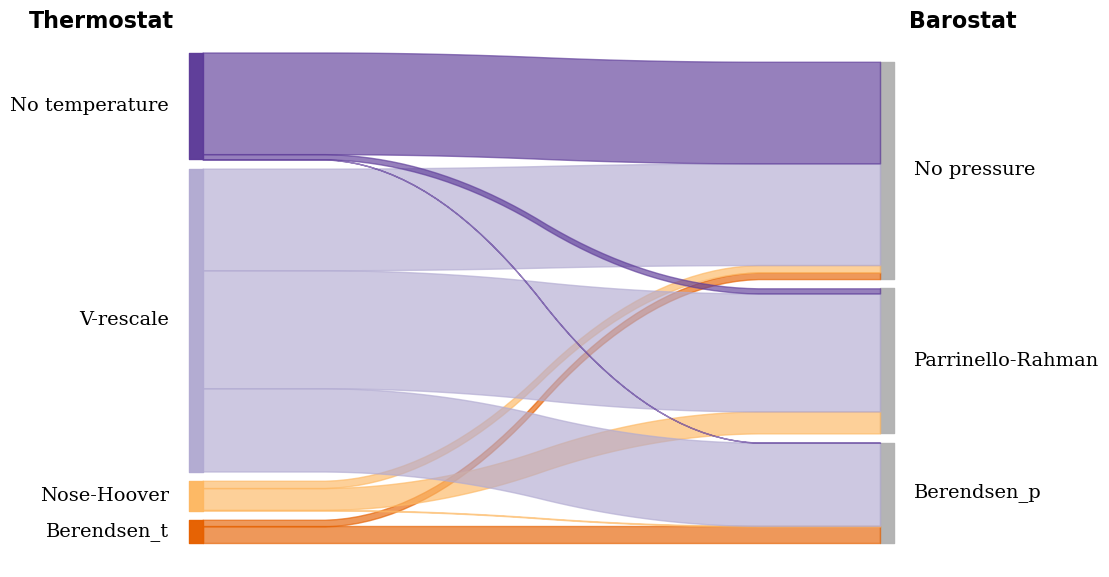

In [174]:
def plot_thermostat_barostat_sankey_graph(df):
    """Plot sankey graph with thermostats and barostats."""
    colorDict = {
        "Berendsen_t": "#e66101",
        "Nose-Hoover": "#fdb863",
        "V-rescale": "#b2abd2",
        "No temperature": "#5e3c99",
        "Parrinello-Rahman": "#b3b3b3",
        "No pressure": "#b3b3b3",
        "Berendsen_p": "#b3b3b3",
    }
    plt.rcParams.update({"font.family": "sans-serif"})
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sankey(
        df["thermostat"], df["barostat"], aspect=10, colorDict=colorDict,
        leftLabels=["Berendsen_t", "Nose-Hoover", "V-rescale", "No temperature"],
        rightLabels=["Berendsen_p","Parrinello-Rahman","No pressure"],
        fontsize=14
    )
    plt.figtext(0.00, 0.88, "Thermostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    plt.figtext(0.88, 0.88, "Barostat", fontsize=16, fontweight="bold", fontfamily="sans-serif")
    filename = "fig/gromacs_thermostat_barostat"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")


plot_thermostat_barostat_sankey_graph(mdp_df)

In [175]:
pd.crosstab(index=mdp_df["thermostat"], columns=mdp_df["barostat"], margins=True, margins_name="Total")

barostat,Berendsen_p,No pressure,Parrinello-Rahman,Total
thermostat,,,,
Berendsen_t,305,127,0,432
No temperature,1,1931,98,2030
Nose-Hoover,10,139,416,565
V-rescale,1581,1931,2241,5753
Total,1897,4128,2755,8780


In [176]:
pairs = pd.crosstab(index=mdp_df["thermostat"], columns=mdp_df["barostat"]).stack().reset_index()
pairs.columns = ["thermostat", "barostat", "value"]
pairs

,thermostat,barostat,value
0,Berendsen_t,Berendsen_p,305
1,Berendsen_t,No pressure,127
2,Berendsen_t,Parrinello-Rahman,0
3,No temperature,Berendsen_p,1
4,No temperature,No pressure,1931
5,No temperature,Parrinello-Rahman,98
6,Nose-Hoover,Berendsen_p,10
7,Nose-Hoover,No pressure,139
8,Nose-Hoover,Parrinello-Rahman,416
9,V-rescale,Berendsen_p,1581


In [181]:
labels = pd.concat([pairs["thermostat"], pairs["barostat"]]).drop_duplicates().reset_index(drop=True)
labels_dict = dict(zip(labels.values, labels.index))
labels_dict

{'Berendsen_t': 0,
 'No temperature': 1,
 'Nose-Hoover': 2,
 'V-rescale': 3,
 'Berendsen_p': 4,
 'No pressure': 5,
 'Parrinello-Rahman': 6}

In [182]:
pairs["thermostat_index"] = pairs["thermostat"].apply(lambda x: labels_dict[x])
pairs["barostat_index"] = pairs["barostat"].apply(lambda x: labels_dict[x])

In [183]:
import plotly.graph_objects as go

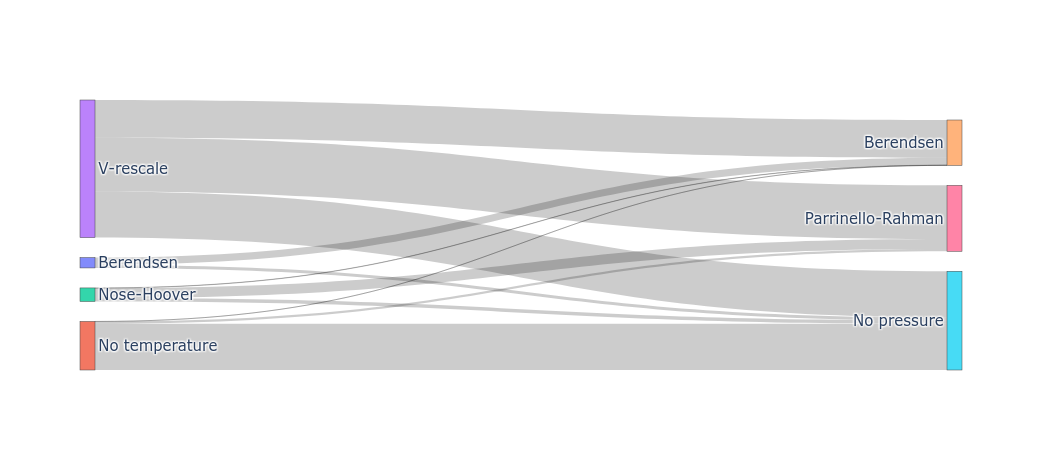

In [184]:
link = {"source": pairs["thermostat_index"].to_list(),
       "target": pairs["barostat_index"].to_list(),
       "value": pairs["value"].to_list()}
node = {
    "label": ["Berendsen", "No temperature", "Nose-Hoover", "V-rescale", "Berendsen", "No pressure", "Parrinello-Rahman"],
    "pad": 20,
    "thickness": 15
}
data=go.Sankey(link=link, node=node)
fig = go.Figure(data)
fig.update_layout(font_size=15, autosize=False, width=700)
fig.update_yaxes(ticklabelposition = "outside")
fig.show()

## Watermark

In [185]:
%load_ext watermark
%watermark --python --machine
print("")
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,upsetplot --iversions --watermark
# Name of conda environment
%watermark --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.6.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit


jupyterlab: 3.5.2
upsetplot : 0.8.0

numpy     : 1.24.1
yaml      : 6.0
pandas    : 1.5.2
plotly    : 5.12.0
matplotlib: 3.5.3

Watermark: 2.3.1

conda environment: mdda

